### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division
import os
import tensorflow as tf
import numpy as np
from nets import vgg
from matplotlib import pyplot as plt
from preprocessing import vgg_preprocessing
from libs.training import get_labels_from_annotation
# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
slim = tf.contrib.slim

# Data processing

In [2]:
#0:   background
#1:   aeroplane
#2:   bicycle
#3:   bird
#4:   boat
#5:   bottle
#6:   bus
#7:   car
#8:   cat
#9:   chair
#10:  cow
#11:  diningtable
#12:  dog
#13:  horse
#14:  motorbike
#15:  person
#16:  pottedplant
#17:  sheep
#18:  sofa
#19:  train
#20:  tvmonitor
#255: undefined/don't care
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [3]:
checkpoints_dir = '/home/thalles/image-segmentation/vgg'
log_folder = '/home/thalles/log_folder'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [4]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

### Loss function definition and training using Adam Optimization Algorithm.

In [5]:
def model(processed_images, number_of_classes=21, is_training=True):
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        _, end_points = vgg.vgg_16(processed_images,
                                         num_classes=number_of_classes,
                                         is_training=True,
                                         spatial_squeeze=False,
                                         scope='vgg_16')

        input_shape = tf.shape(processed_images)

        #vgg_fc6_feature = end_points['vgg_16/fc6']
        
        # get the vggs pool5 feature map
        pool5_feature_map = end_points['vgg_16/pool5']
        pool5_feature_shape = tf.shape(pool5_feature_map)

        pool4_feature_map = end_points['vgg_16/pool4']
        pool4_feature_shape = tf.shape(pool4_feature_map)

        pool3_feature_map = end_points['vgg_16/pool3']
        pool3_feature_shape = tf.shape(pool3_feature_map)

        pool2_feature_map = end_points['vgg_16/pool2']
        pool2_feature_shape = tf.shape(pool2_feature_map)

        pool1_feature_map = end_points['vgg_16/pool1']
        pool1_feature_shape = tf.shape(pool1_feature_map)

        with tf.variable_scope("seg_vars"):
            
            # Merging Pooling 4 layer
            pool5_feature_resized = tf.image.resize_images(pool5_feature_map, 
                                                           [pool4_feature_shape[1],pool4_feature_shape[2]], method=0)
            pool5_feature_conv = slim.conv2d(pool5_feature_resized, 512, [3, 3], activation_fn=None)

            pool4_feature_conv = slim.conv2d(pool4_feature_map,
                                   512,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool5_conv_plus_poo4_conv = pool5_feature_conv + pool4_feature_conv
            
            # Merging Pooling 3 layer
            pool4_feature_resized = tf.image.resize_images(pool5_conv_plus_poo4_conv, 
                                                           (pool3_feature_shape[1], pool3_feature_shape[2]), method=0)
            pool4_feature_conv = slim.conv2d(pool4_feature_resized, 256, [3, 3], activation_fn=None)
            #pool4_feature_conv = tf.contrib.layers.batch_norm(pool4_feature_conv)
            
            pool3_feature_conv = slim.conv2d(pool3_feature_map,
                                   256,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool4_conv_plus_pool3_conv = pool4_feature_conv + pool3_feature_conv

            # Merging Pooling 2 layer
            pool3_feature_resized = tf.image.resize_images(pool4_conv_plus_pool3_conv, 
                                                           (pool2_feature_shape[1], pool2_feature_shape[2]), method=0)
            pool3_feature_conv = slim.conv2d(pool3_feature_resized, 128, [3, 3], activation_fn=None)
            #pool3_feature_conv = tf.contrib.layers.batch_norm(pool3_feature_conv)
            
            pool2_feature_conv = slim.conv2d(pool2_feature_map,
                                   128,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool3_conv_plus_pool2_conv = pool3_feature_conv + pool2_feature_conv

            # Merging Pooling1 layer
            pool2_feature_resized = tf.image.resize_images(pool3_conv_plus_pool2_conv, 
                                                           (pool1_feature_shape[1], pool1_feature_shape[2]), method=0)
            pool2_feature_conv = slim.conv2d(pool2_feature_resized, 64, [3, 3], activation_fn=None)
            #pool2_feature_conv = tf.contrib.layers.batch_norm(pool2_feature_conv)
            
            pool1_feature_conv = slim.conv2d(pool1_feature_map,
                                   64,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool2_conv_plus_pool1_conv = pool2_feature_conv + pool1_feature_conv
            
            # Resize to original image shape
            orignal_image_shape = tf.image.resize_images(pool2_conv_plus_pool1_conv, 
                                                           (input_shape[1], input_shape[2]), method=0)
            orignal_image_conv = slim.conv2d(orignal_image_shape, 64, [3, 3], activation_fn=None)
            
            orignal_image_logits = slim.conv2d(orignal_image_conv, number_of_classes, [3, 3], activation_fn=None)
            return orignal_image_logits

In [6]:
def model_loss(upsampled_by_factor_16_logits, labels):

    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=upsampled_by_factor_16_logits,
                                                              labels=labels)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [7]:
def model_optimizer(cross_entropy_sum, learning_rate):
    # Here we define an optimizer and put all the variables
    # that will be created under a namespace of 'adam_vars'.
    # This is done so that we can easily access them later.
    # Those variables are used by adam optimizer and are not
    # related to variables of the vgg model.

    # We also retrieve gradient Tensors for each of our variables
    # This way we can later visualize them in tensorboard.
    # optimizer.compute_gradients and optimizer.apply_gradients
    # is equivalent to running:
    # train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
    with tf.variable_scope("adam_vars"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
        train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    return train_step

In [8]:
num_classes = 21
input_shape = (384,384,3)
annotation_shape = (384,384)
total_epochs = 30
batch_size = 20
image_size=[384, 384]
total_train_steps = 50

In [9]:
# read the input and annotation images
image_tensor = tf.read_file("./images/cat.jpg")
image_tensor = tf.image.decode_jpeg(image_tensor, channels=3) 
image_tensor = tf.cast(image_tensor, tf.float32)
image_tensor = _mean_image_subtraction(image_tensor,[_R_MEAN, _G_MEAN, _B_MEAN])
image_tensor = tf.expand_dims(image_tensor, axis=0) # (1, ?, ?, 3) # BATCH,WIDTH,HEIGHTxDEPTH

annotation_tensor = tf.read_file("./labels/cat_annotation.png")
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
annotation_masks_tensor = get_labels_from_annotation(tf.squeeze(annotation_tensor), class_labels)
annotation_masks_tensor = tf.expand_dims(annotation_masks_tensor, axis=0) # BATCH,WIDTH,HEIGHT

In [10]:
#with tf.Session() as sess:
#    image = sess.run(image_tensor)
#    print(image)

In [11]:
is_training_placeholder = model_input()

upsampled_by_factor_16_logits = model(image_tensor, number_of_classes=number_of_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, annotation_masks_tensor)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.00001)

In [12]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=annotation_tensor,
                                                   num_classes=number_of_classes)

In [13]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles/image-segmentation/vgg/vgg_16.ckpt


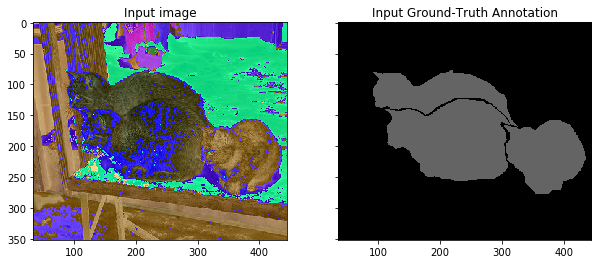

Train step: 0 	Traing Loss: 22.4037 	mIOU: 0.0144642


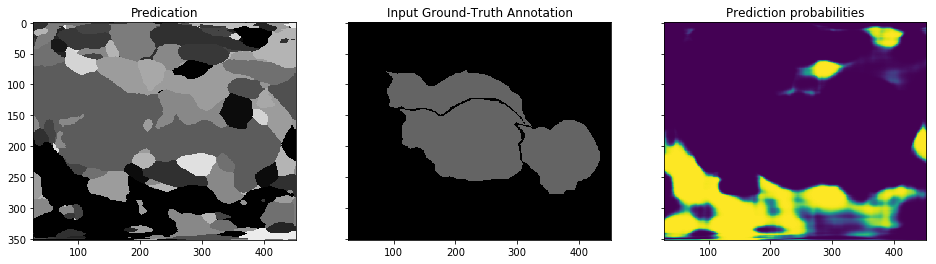

Train step: 1 	Traing Loss: 2.60876 	mIOU: 0.037464


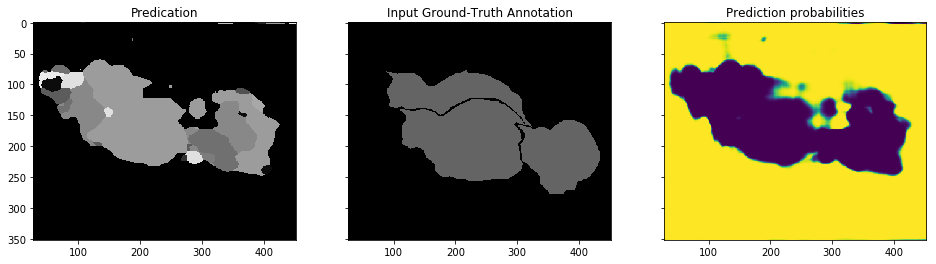

Train step: 2 	Traing Loss: 0.749807 	mIOU: 0.0510951


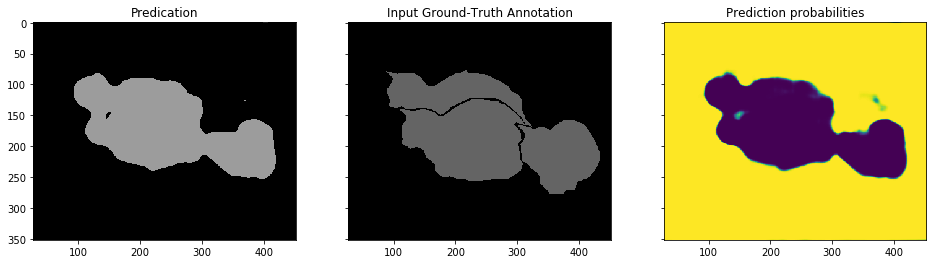

Train step: 3 	Traing Loss: 0.377287 	mIOU: 0.0594328


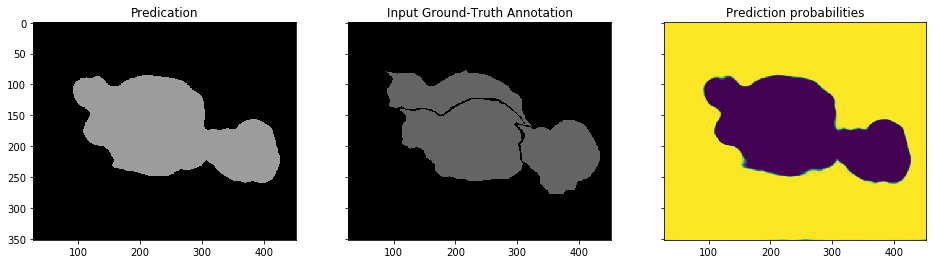

Train step: 4 	Traing Loss: 0.281579 	mIOU: 0.0650463


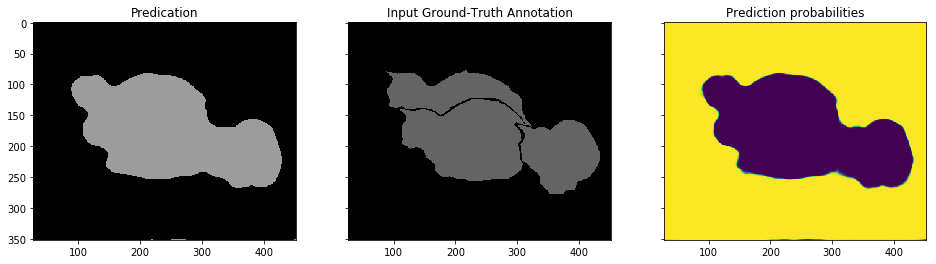

Train step: 5 	Traing Loss: 0.336902 	mIOU: 0.0688897


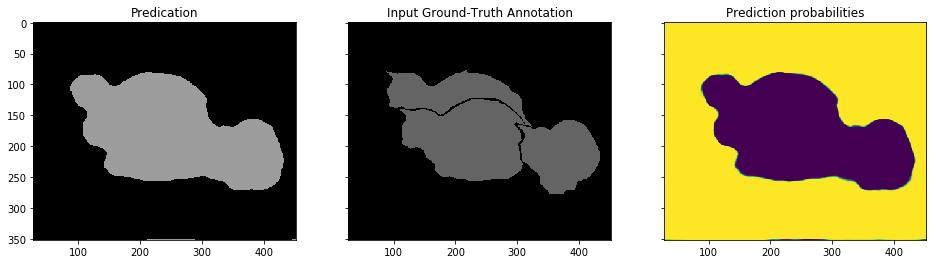

Train step: 6 	Traing Loss: 0.348188 	mIOU: 0.0716475


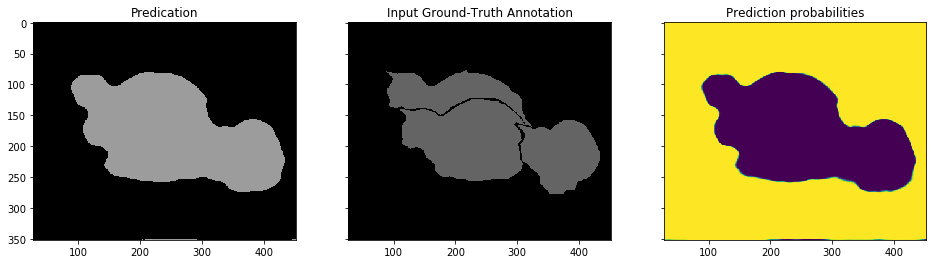

Train step: 7 	Traing Loss: 0.303598 	mIOU: 0.0737689


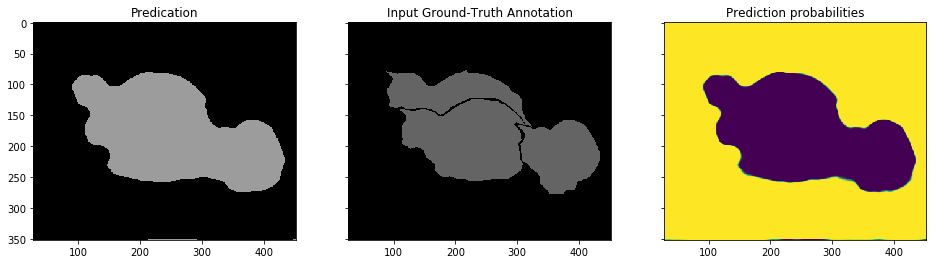

Train step: 8 	Traing Loss: 0.259234 	mIOU: 0.0754441


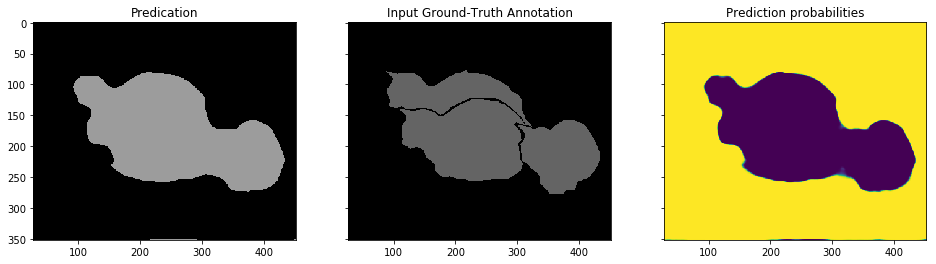

Train step: 9 	Traing Loss: 0.253854 	mIOU: 0.0767728


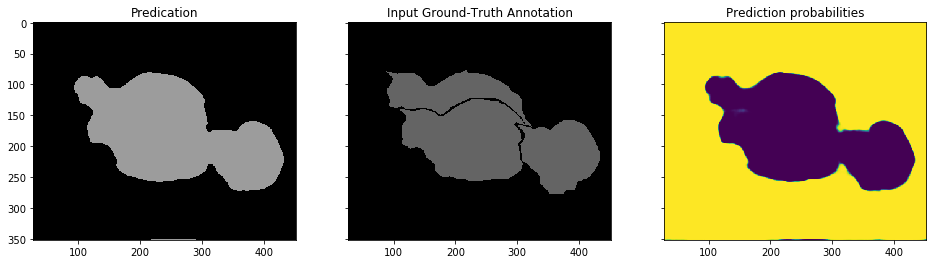

In [14]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict={is_training_placeholder: False})
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figheight(4)
    f.set_figwidth(10)
    ax1.imshow(train_image[0])
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    for step in range(10):

        _, train_loss, pred_np, probabilities_np, tmp = sess.run([train_step, cross_entropy_sum, pred, probabilities, update_op],
                                        feed_dict={is_training_placeholder: True})
        miou_np = sess.run(miou)
        
        pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
        print("Train step:", step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np)

        cmap = plt.get_cmap('bwr')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_figheight(4)
        f.set_figwidth(16)

        ax1.imshow(np.dstack((pred_annotation,)*3)*100)
        ax1.set_title('Predication')
        probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
        ax2.set_title('Input Ground-Truth Annotation')
        probability_graph = ax3.imshow(probabilities_np.squeeze()[:, :, 0])
        ax3.set_title('Prediction probabilities')
        plt.show()

    sess.close()

    summary_string_writer.close()